# Spaceship Titanic

## Overview

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, 
the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets 
orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic
collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000
years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the 
Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal
records recovered from the ship's damaged computer system.

## File and Data Field Descriptions

### train.csv 

Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

Sure! Here's the code converted to a markdown table:

| Column Name | Description |
|------------- |-------------|
| `PassengerId` | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| `HomePlanet` | The planet the passenger departed from, typically their planet of permanent residence. |
| `CryoSleep` | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. |
| `Cabin` | The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. |
| `Destination` | The planet the passenger will be debarking to. |
| `Age` | The age of the passenger. |
| `VIP` | Whether the passenger has paid for special VIP service during the voyage. |
| `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| `Name` | The first and last names of the passenger. |
| `Transported` | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

### test.csv

Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. 

Your task is to predict the value of Transported for the passengers in this set.
    
### sample_submission.csv

A sample submission file in the correct format.

| Column Name | Description |
|------------- |-------------|
| `PassengerId` | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| `Transported` | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

In [1]:
# Library imports

# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

## Import data and review

In [2]:
# Load the data - to pandas dataframes

test_df = pd.read_csv('./inputs/test.csv')
test_idx = test_df['PassengerId']
train_df = pd.read_csv('./inputs/train.csv')

In [3]:
# Look at the training data
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Look at the test data
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
# Check the shape of the data
print("Training shape: ", train_df.shape)
print("Test     shape: ", test_df.shape)

Training shape:  (8693, 14)
Test     shape:  (4277, 13)


## Exploratory Data Analysis

### Column information and nulls

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
train_df.isnull().sum().sort_values(ascending = False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

In [8]:
test_df.isnull().sum().sort_values(ascending = False)

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64

<Axes: >

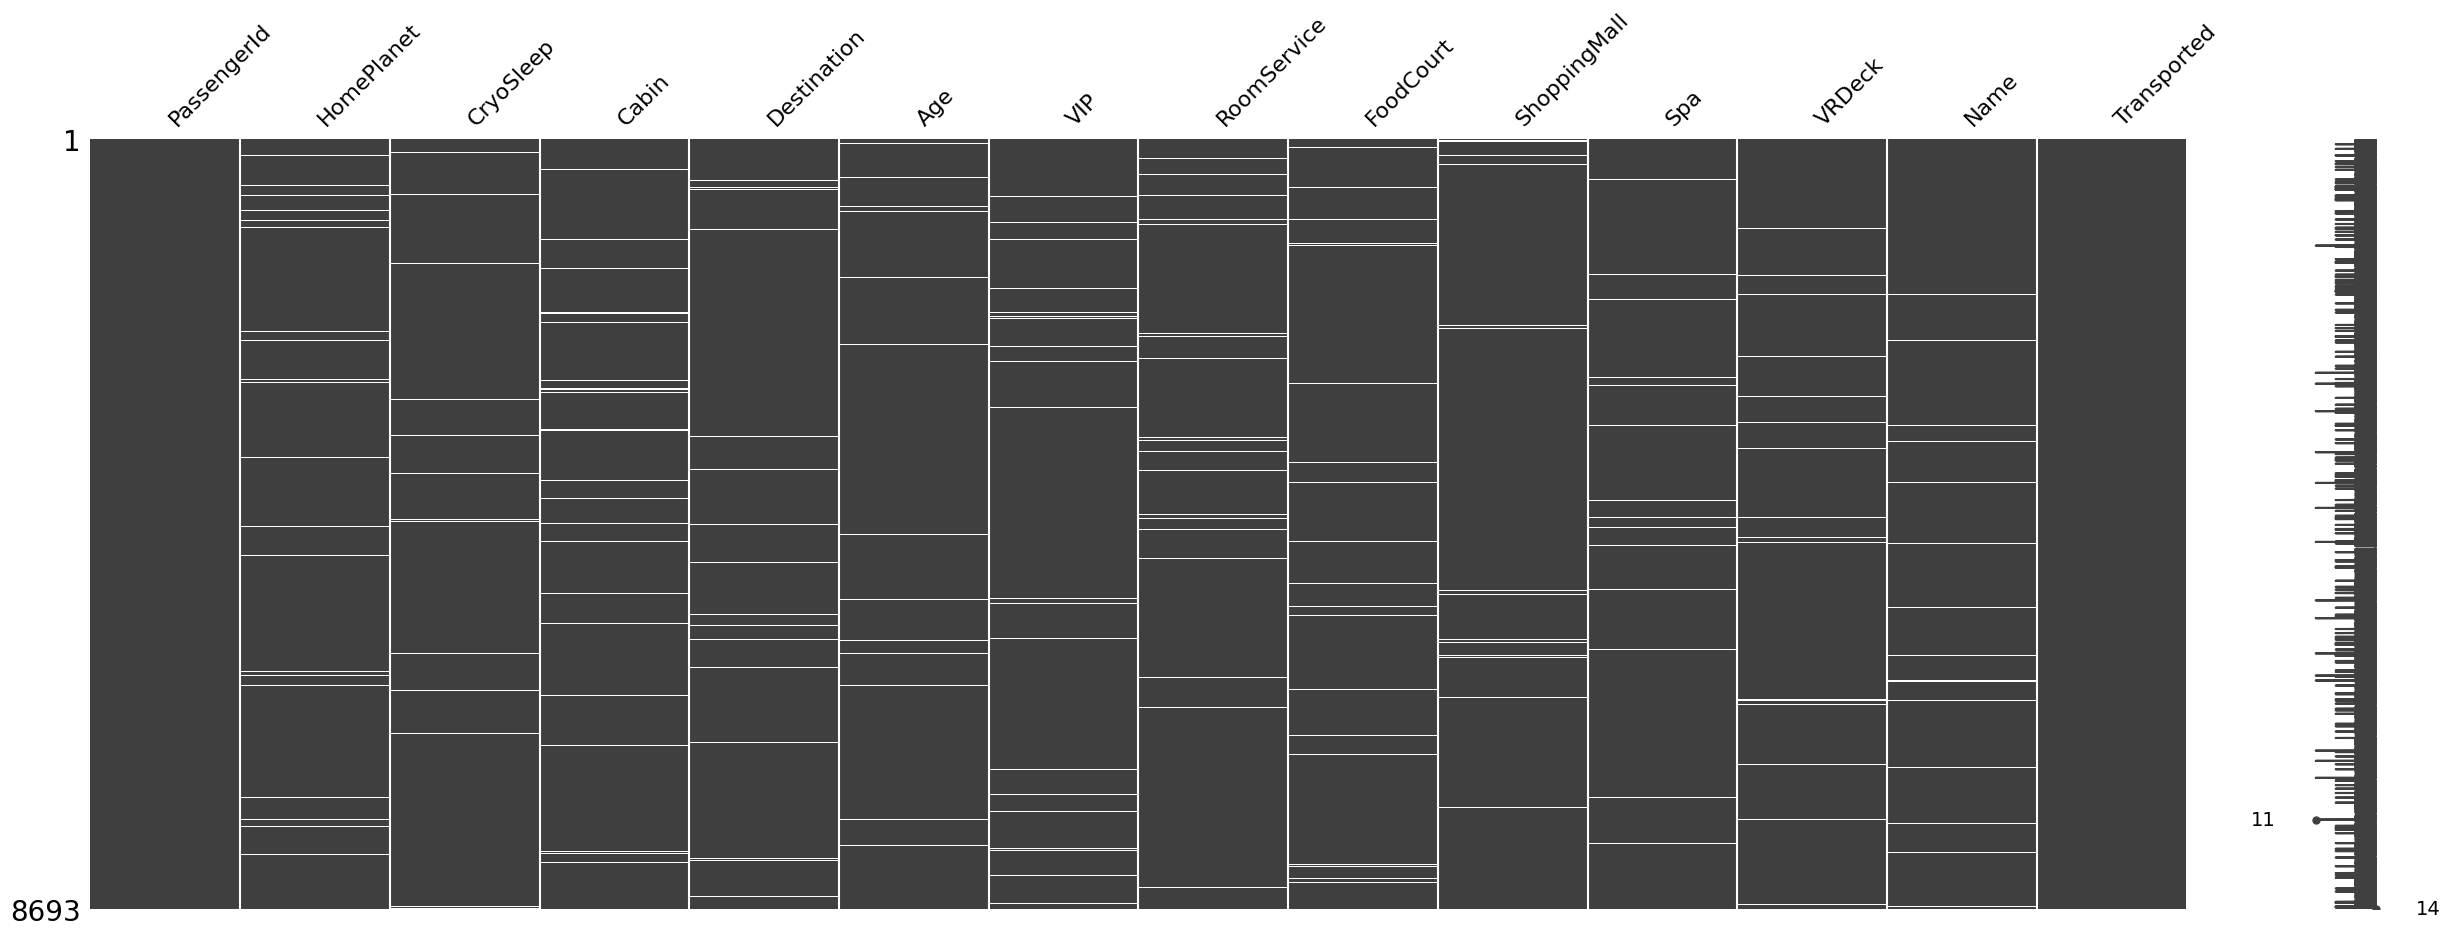

In [9]:
# Visualise missing data
missingno.matrix(train_df, figsize = (30,10))

In the training set we have a small percentage of **null** values in all columns. We need to decide how to treat these.

<Axes: >

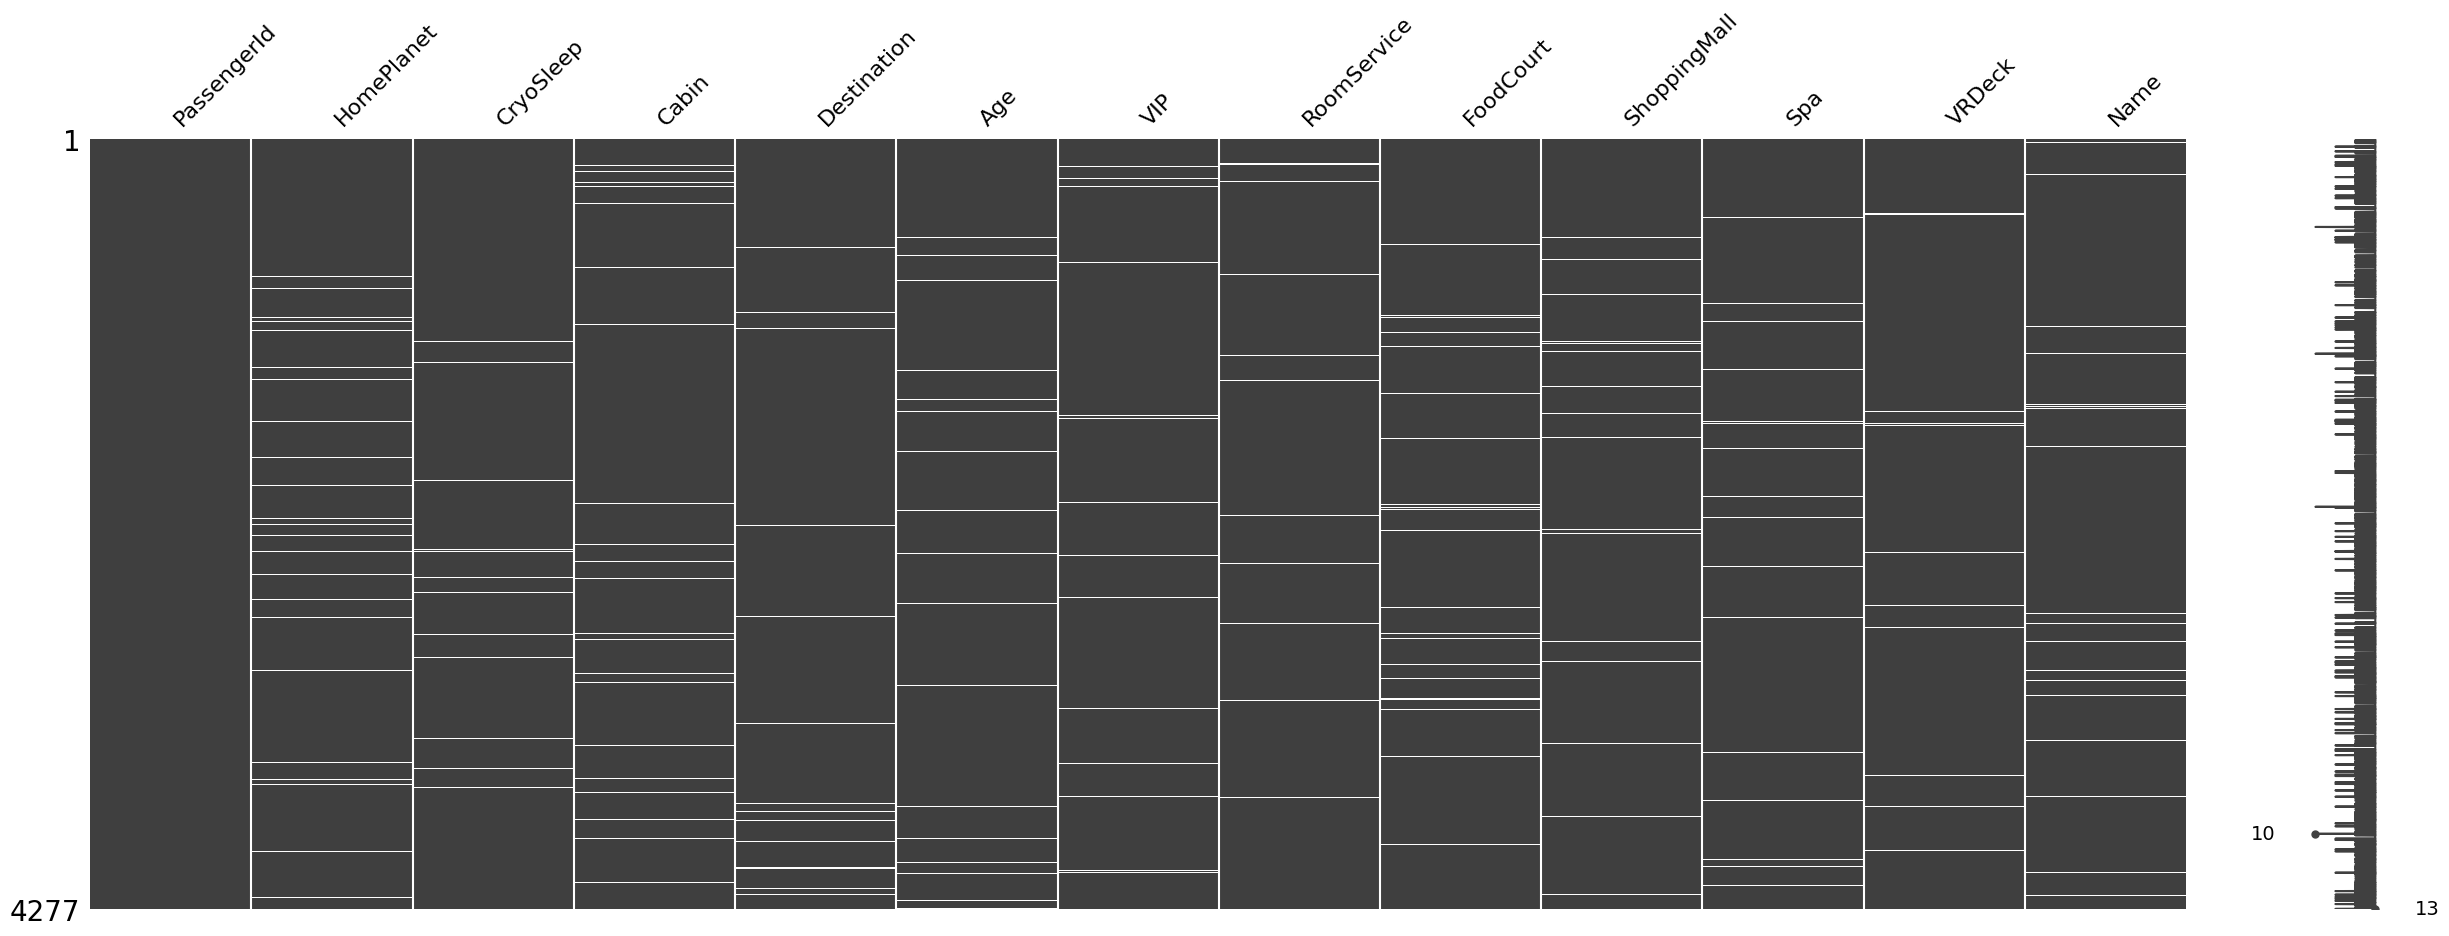

In [10]:
missingno.matrix(test_df, figsize = (30,10))

Same situation with the test set - small number of **null** values dispersed widely

### Data descriptions of numerics

In [11]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [12]:
test_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


Most of these values have quite high variance and will need to be scaled

### Categorical features

In terms of categorical features we have 

- HomePlanet
- CryoSleep
- Cabin
- Destination
- VIP
- Name

Let's explore these:

In [13]:
# This function will create a dataframe containing the value counts and percentages each value with Transported = 1
def print_value_counts_and_percentages(df, column_name, sort_by='Transported', head_count=None):

    # Group by the column and calculate the mean of 'Transported'
    result = df[[column_name, 'Transported']].groupby(column_name, as_index = False).mean()
    
    # Convert the mean of 'Transported' to percentage
    result['Transported'] = result['Transported'] * 100
    
    # Extract the value counts of the column
    counts = df[column_name].value_counts()

    # map the counts to the result    
    result['Counts'] = result[column_name].map(counts)

    # Sort the dataframe by 'Transported' in descending order - strongest correlation with 'Transported' at the top
    if sort_by == 'Transported':
        result = result.sort_values(by='Transported', ascending=False)
    elif sort_by == 'Counts':
        result = result.sort_values(by='Counts', ascending=False)

    if head_count is not None:
        result = result.head(head_count)
    print(result)
 

In [14]:
print_value_counts_and_percentages(train_df, 'HomePlanet')

  HomePlanet  Transported  Counts
1     Europa    65.884561    2131
2       Mars    52.302445    1759
0      Earth    42.394611    4602


Text(0.5, 1.0, 'Transported Probability by HomePlanet')

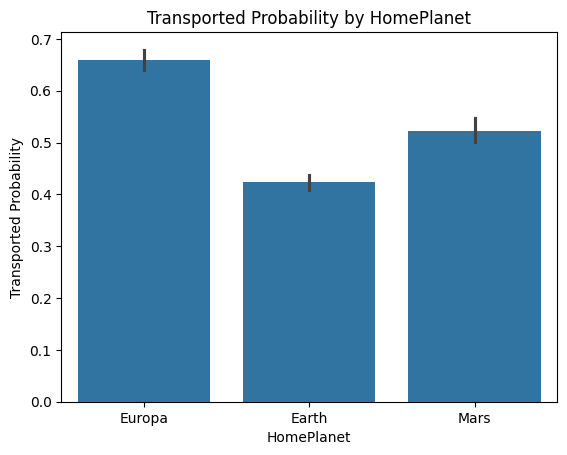

In [15]:
sns.barplot(x = 'HomePlanet', y ='Transported', data = train_df)
plt.ylabel('Transported Probability')
plt.title('Transported Probability by HomePlanet')

# Earth is safest then Mars then Europa

In [16]:
print_value_counts_and_percentages(train_df, 'CryoSleep')

# People who were in CryoSleep have a higher chance of being transported

  CryoSleep  Transported  Counts
1      True    81.758314    3037
0     False    32.892076    5439


In [17]:
print_value_counts_and_percentages(train_df, 'Cabin')

# Cabins are too fine grained to be useful in current form

         Cabin  Transported  Counts
6559     T/3/P        100.0       1
2004   E/513/S        100.0       1
4581  G/1012/P        100.0       1
4580  G/1011/S        100.0       1
2008   E/516/P        100.0       1
...        ...          ...     ...
4263   F/797/P          0.0       1
4264   F/797/S          0.0       1
2295  F/1077/P          0.0       1
2291  F/1075/P          0.0       1
3280  F/1763/S          0.0       1

[6560 rows x 3 columns]


In [18]:
print_value_counts_and_percentages(train_df, 'Destination')

# 55 Cancri e is the most dangerous then PSO J318.5-22 and TRAPPIST-1e. This said the correlation is not very strong

     Destination  Transported  Counts
0    55 Cancri e    61.000000    1800
1  PSO J318.5-22    50.376884     796
2    TRAPPIST-1e    47.117498    5915


In [19]:
print_value_counts_and_percentages(train_df, 'VIP')

# VIPs are less likely to be transported but there are so few it is probably not that useful

     VIP  Transported  Counts
0  False    50.633217    8291
1   True    38.190955     199


In [20]:
print_value_counts_and_percentages(train_df, 'Name')

# Names are too fine grained to be useful in current form

                    Name  Transported  Counts
4236      Jeanie Moodsey        100.0       1
6741     Roydo Hammonton        100.0       1
3517  Graston Invebodene        100.0       1
3516   Graston Donotaked        100.0       1
3515   Grastab Tairbatic        100.0       1
...                  ...          ...     ...
3832        Hene Braymon          0.0       1
3827      Hencey Chanash          0.0       1
3825  Hencey Bulliamoses          0.0       1
3823       Hen Hubbarton          0.0       1
8472    Zubeneb Pasharne          0.0       1

[8473 rows x 3 columns]


Reviewing our categorical data so far we can see the following:

- `HomePlanet` - Earth is safest then Mars then Europa 
- `CryoSleep`  - People who were in CryoSleep have a higher chance of being transported (Strong)
- `Destination` - 55 Cancri e is the most dangerous then PSO J318.5-22 and TRAPPIST-1e 
- `VIP` - VIPs are less likely to be transported but there are so few it is probably not that useful?
- `Cabin` & `Name` - too fine grained to be useful as they are

So we have 4 correlated categorical variables with one strongly correlated (`Cryosleep`)

Let's see if we can get anything useful out of Name and Cabin

In [21]:
# split name into components
def split_name(name:str):
    if pd.isnull(name): # protect against empty values
        return (np.nan, np.nan, np.nan)
    parts = name.split(' ')
    first = parts[0]
    last = parts[-1]
    return (first, last)

train_df['First'], train_df['Last'] = zip(*train_df['Name'].map(split_name))

In [22]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,First,Last
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines


In [23]:
print_value_counts_and_percentages(train_df, 'Last', sort_by = 'Counts', head_count = 20)

             Last  Transported  Counts
356     Casonston    38.888889      18
1447      Oneiles    37.500000      16
1205     Litthews    26.666667      15
604     Domington    93.333333      15
818        Garnes    35.714286      14
347        Cartez    50.000000      14
799     Fulloydez    42.857143      14
260    Browlerson    64.285714      14
979    Hinglendez    61.538462      13
113        Barbes    76.923077      13
602      Distured    46.153846      13
851    Gibbsonton    38.461538      13
249     Briggston    30.769231      13
1351      Moodman    23.076923      13
2097       Vandan    58.333333      12
843     Georgasey    58.333333      12
807       Gainney    41.666667      12
2115        Vloaf    58.333333      12
916        Hanner    16.666667      12
754   Fowlesterez    50.000000      12


In [24]:
print_value_counts_and_percentages(train_df, 'First', sort_by = 'Counts', head_count = 20)

       First  Transported  Counts
1282   Idace    15.384615      13
1568   Loree    58.333333      12
1442    Kaye    54.545455      11
703   Dandra    36.363636      11
1168  Gwendy    36.363636      11
1078   Glena    54.545455      11
72       Ale    40.000000      10
364    Benny    20.000000      10
1573  Lorian    20.000000      10
397   Blancy    40.000000      10
936    Eulah    40.000000      10
2555  Violan     0.000000      10
913    Eriky    30.000000      10
911     Erie    40.000000      10
1917  Patoya    20.000000      10
449   Breney    50.000000      10
727   Delley    30.000000      10
1690  Melica    70.000000      10
1514  Leneva    60.000000      10
1397  Jorgie    60.000000      10


Despite all of this it is hard to see much in the way of a pattern but may be worth keeping Last and dropping First & Name:

Now cabin...

In [25]:
# split cabin into components
def split_cabin(name:str):
    if pd.isnull(name): # protect against empty values
        return (np.nan, np.nan, np.nan)
    parts = name.split('/')
    deck = parts[0]
    side = parts[-1]
    number = ' '.join(parts[1:-1])
    return (deck, number, side)

train_df['Deck'], train_df['Number'], train_df['Side'] = zip(*train_df['Cabin'].map(split_cabin))


In [26]:
# Lets Create new features by combining the cabin sub-features in case they were previously too coarse grained
train_df['DeckSide'] = train_df['Deck'] + train_df['Side']

In [27]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,First,Last,Deck,Number,Side,DeckSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,B,0,P,BP
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,F,0,S,FS
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,A,0,S,AS
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,A,0,S,AS
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,F,1,S,FS


In [28]:
print_value_counts_and_percentages(train_df, 'Deck')

# Deck actually seems pretty promising there is a significant correlation with being transported

  Deck  Transported  Counts
1    B    73.427471     779
2    C    68.005355     747
6    G    51.621727    2559
0    A    49.609375     256
5    F    43.987115    2794
3    D    43.305439     478
4    E    35.730594     876
7    T    20.000000       5


In [29]:
print_value_counts_and_percentages(train_df, 'Number')

# Number is not very useful

    Number  Transported  Counts
301   1273        100.0       3
169   1151        100.0       1
171   1153        100.0       3
668   1618        100.0       1
664   1614        100.0       1
..     ...          ...     ...
711   1663          0.0       1
712   1664          0.0       2
713   1665          0.0       1
714   1666          0.0       2
908   1877          0.0       1

[1817 rows x 3 columns]


In [30]:
print_value_counts_and_percentages(train_df, 'Side')

# Side is somewhat helpful

  Side  Transported  Counts
1    S    55.503731    4288
0    P    45.126010    4206


In [31]:
print_value_counts_and_percentages(train_df, 'DeckSide')

   DeckSide  Transported  Counts
3        BS    78.403756     426
5        CS    76.354680     406
2        BP    67.422096     353
13       GS    58.378800    1283
4        CP    58.064516     341
1        AS    54.676259     139
11       FS    47.050147    1356
7        DS    46.521739     230
12       GP    44.827586    1276
0        AP    43.589744     117
10       FP    41.098748    1438
6        DP    40.322581     248
9        ES    37.136465     447
8        EP    34.265734     429
14       TP    25.000000       4
15       TS     0.000000       1


So to summarise all this we have Deck looking very good and Side looking ok with Number awful. Combining Deck and Side seems to get a good balance of correlation and number of categories

In [32]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,First,Last,Deck,Number,Side,DeckSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,B,0,P,BP
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,F,0,S,FS
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,A,0,S,AS
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,A,0,S,AS
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,F,1,S,FS


`PassengerId` is actually made up of a group as everything before the underscore so we could treat this as a categorical feature

In [33]:
train_df['Group'] = train_df['PassengerId'].map(lambda x: x.split('_')[0])

In [34]:
print_value_counts_and_percentages(train_df, 'Group', sort_by='Counts', head_count=20)

     Group  Transported  Counts
3023  4498    37.500000       8
5487  8168    37.500000       8
5851  8728    37.500000       8
5893  8796    50.000000       8
6000  8956    12.500000       8
2858  4256    25.000000       8
654   0984    37.500000       8
6084  9081    50.000000       8
6021  8988    50.000000       8
3874  5756    12.500000       8
3966  5885    62.500000       8
2681  4005    62.500000       8
3446  5133    37.500000       8
2801  4176    71.428571       7
806   1211    42.857143       7
484   0714    57.142857       7
4298  6363    28.571429       7
4571  6787    57.142857       7
5875  8770    42.857143       7
2797  4172    57.142857       7


In [35]:
train_df['GroupSize'] = train_df['Group'].map(train_df['Group'].value_counts())

In [36]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,First,Last,Deck,Number,Side,DeckSide,Group,GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,Maham,Ofracculy,B,0,P,BP,0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,Juanna,Vines,F,0,S,FS,0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,Altark,Susent,A,0,S,AS,0003,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Solam Susent,False,Solam,Susent,A,0,S,AS,0003,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Willy Santantines,True,Willy,Santantines,F,1,S,FS,0004,1


### Summary of Categorical Features

- `HomePlanet`, `CryoSleep`, `Destination`, `VIP` all seem potentially useful
- We have `DeckSide` that seems decent & `Last` derrived from `Cabin` and `Name` respectively that should help
- `Group` may help with empty values

`GroupSize` derrived from group may be a useful numeric feature

## Numerical Features

Now we can explore our numerical features which are

- Age
- RoomService	
- FoodCourt	
- ShoppingMall	
- Spa	
- VRDeck
- GroupSize

Here we will handle outliers and look for correlation to the target variable `Transported`

### Outliers

Outliers are values that are significantly bigger or smaller than most data. They can skew mean and standard deviation and most ML models expect noramally distributed data. For this reason it is good practice to remove outliers.

Mathematically an outlier is defined as either:

- a value greater than the 75 percentile + (1.5 * IQR)
- a value less than than the 25 percentile - (1.5 * IQR)

Where IQR = interquartile range = 75th percentile - 25th percentile

In pandas we can get the 75th and 25th percentiles using `.quantile()` method on a dataframe column

In [37]:
def outliers(df: str, columns: list, outliers_to_drop = 1):
    all_outliers = []

    for column in columns:
        # Calculate the 25 and 75 percentiles of the column
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)

        # Calculate the interquartile range
        iqr = q3 - q1
        
        # Calculate the lower and upper bounds to be an outlier
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        # Find the indices of the outliers for this column
        outliers_for_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        
        # Add the indices to the list of all outliers indices
        all_outliers.extend(outliers_for_column)
    
    # Counter object is a dictionary where the keys are the unique elements in the original all_outliers list, and the values are the counts of these elements.
    count_outlier_indices = Counter(all_outliers)
    # Create a list of the indices that are outliers for outliers_to_drop column(s) or more
    return [index for index, count in count_outlier_indices.items() if count >= outliers_to_drop]
        


In [38]:
for outlier_limit in range(1, 6):
    outliers_to_drop = outliers(train_df, ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], outlier_limit)
    print(f'With a limit of {outlier_limit}, of {len(train_df)} we would drop {len(outliers_to_drop)} rows')

With a limit of 1, of 8693 we would drop 5030 rows
With a limit of 2, of 8693 we would drop 2992 rows
With a limit of 3, of 8693 we would drop 982 rows
With a limit of 4, of 8693 we would drop 170 rows
With a limit of 5, of 8693 we would drop 13 rows


So it seems we have to have quite a few rows if we go with this approach which makes me think maybe we should try an alternative

I am tempted to create categories as follows:

- `Food` = `RoomService` + `FoodCourt`
- `Leisure` = `ShoppingMall`, `Spa`, `VRDeck`

In [39]:
train_df['Food'] = train_df['RoomService'] + train_df['FoodCourt']
train_df['Leisure'] = train_df['ShoppingMall'] + train_df['Spa'] + train_df['VRDeck']

In [40]:
for outlier_limit in range(1, 3):
    outliers_to_drop = outliers(train_df, ['Age', 'Food', 'Leisure'], outlier_limit)
    print(f'With a limit of {outlier_limit}, of {len(train_df)} we would drop {len(outliers_to_drop)} rows')

With a limit of 1, of 8693 we would drop 1498 rows
With a limit of 2, of 8693 we would drop 249 rows


For now I am tempted to go with a limit of 2 and use these aggregations which gives us these

In [41]:
outliers_to_drop = outliers(train_df, ['Age', 'Food', 'Leisure'], 2)
train_df.loc[outliers_to_drop, :]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,First,Last,Deck,Number,Side,DeckSide,Group,GroupSize,Food,Leisure
280,0310_01,Europa,False,NaN,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,...,Naviton,Coudered,NaN,NaN,NaN,NaN,0310,1,NaN,4717.0
338,0378_03,Europa,False,B/11/S,TRAPPIST-1e,79.0,False,5649.0,235.0,7.0,...,Naslon,Pirejus,B,11,S,BS,0378,7,5884.0,4761.0
615,0642_03,Europa,False,C/25/S,TRAPPIST-1e,79.0,False,0.0,0.0,0.0,...,Chabik,Kiling,C,25,S,CS,0642,5,0.0,2212.0
705,0740_01,Europa,False,C/24/P,55 Cancri e,67.0,False,76.0,16.0,0.0,...,Dyonevi,Sageng,C,24,P,CP,0740,3,92.0,3413.0
1390,1455_05,Europa,False,B/62/S,55 Cancri e,76.0,False,0.0,2732.0,422.0,...,Antino,Wassird,B,62,S,BS,1455,5,2732.0,17346.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8487,9069_05,Europa,False,B/297/P,55 Cancri e,29.0,False,0.0,12563.0,0.0,...,Mirfark,Taketiatim,B,297,P,BP,9069,5,12563.0,5060.0
8588,9168_01,Europa,False,C/338/S,55 Cancri e,36.0,False,23.0,14773.0,0.0,...,Hadirk,Cassiding,C,338,S,CS,9168,2,14796.0,8978.0
8613,9194_01,NaN,False,E/603/S,55 Cancri e,53.0,False,0.0,4017.0,0.0,...,NaN,NaN,E,603,S,ES,9194,2,4017.0,3160.0
8621,9197_02,Europa,False,C/308/P,NaN,41.0,True,0.0,7964.0,0.0,...,Aludram,Platch,C,308,P,CP,9197,4,7964.0,9077.0


In [42]:
# Drop outliers and reset index
print("Before: {} rows".format(len(train_df)))
train_df = train_df.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train_df)))

Before: 8693 rows
After: 8444 rows


### Numerical feature correlation

We can now look at whether the original or engineered features correlates with being Transported 

<Axes: >

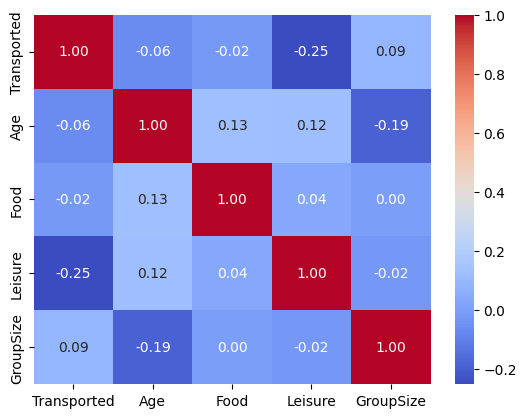

In [43]:
# Start with the engineered features for simplicity

sns.heatmap(train_df[['Transported', 'Age', 'Food', 'Leisure', 'GroupSize']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

# Leisure is the most correlated with being transported it seems to be protective

<Axes: >

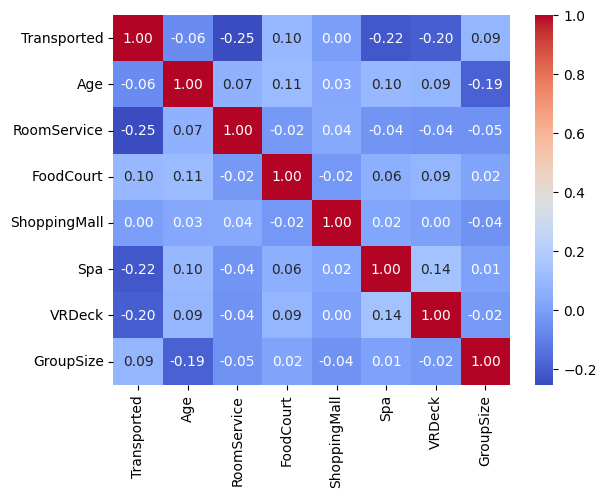

In [44]:
# Now for the original features

sns.heatmap(train_df[['Transported', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

# RoomService and Spa are the most correlated with being transported

### Age variable handling

In [45]:
# Check how many are null
print(f'Age is null in {train_df["Age"].isnull().sum()} out of {len(train_df)} rows')

Age is null in 175 out of 8444 rows


Text(0.5, 1.0, 'Passenger Age Distribution')

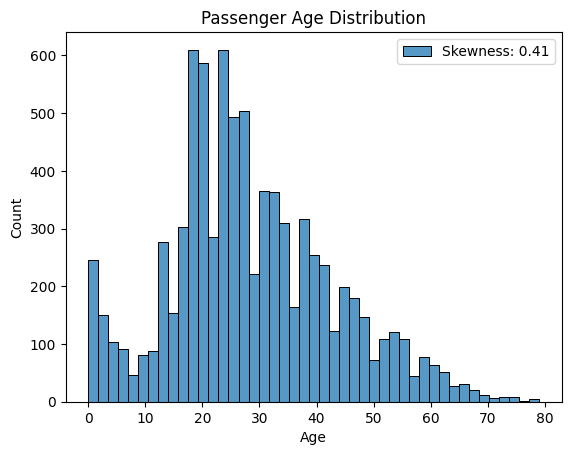

In [46]:
# Age distribution i.e. skew

sns.histplot(train_df['Age'], label = 'Skewness: %.2f'%(train_df['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

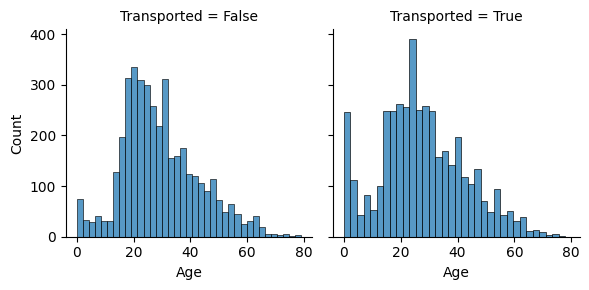

In [47]:
# Age distribution by 'Transported'

g = sns.FacetGrid(train_df, col = 'Transported')
g.map(sns.histplot, 'Age')

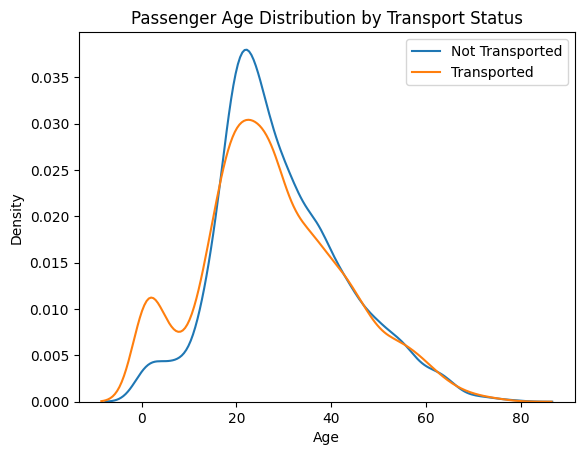

In [48]:
sns.kdeplot(train_df['Age'][train_df['Transported'] == 0], label = 'Not Transported')
sns.kdeplot(train_df['Age'][train_df['Transported'] == 1], label = 'Transported')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Transport Status')
plt.legend()

### RoomService

In [49]:
print(f'RoomService is null in {train_df["RoomService"].isnull().sum()} out of {len(train_df)} rows')

RoomService is null in 180 out of 8444 rows


(0.0, 120.0)

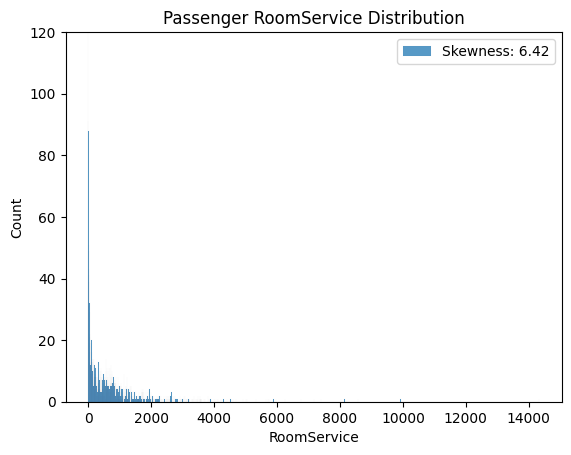

In [50]:
sns.histplot(train_df['RoomService'], label = 'Skewness: %.2f'%(train_df['RoomService'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger RoomService Distribution')
plt.ylim(0,120)

In [51]:
# Print a count of the rows with a zero RoomService
print(f'RoomService is zero in {len(train_df[train_df["RoomService"] == 0])} out of {len(train_df)} rows')

# about 60% are zero which is having a big impact on the skew we can address this by bucketing or log transforming

RoomService is zero in 5433 out of 8444 rows


### Spa

In [52]:
print(f'Spa is null in {train_df["Spa"].isnull().sum()} out of {len(train_df)} rows')

Spa is null in 183 out of 8444 rows


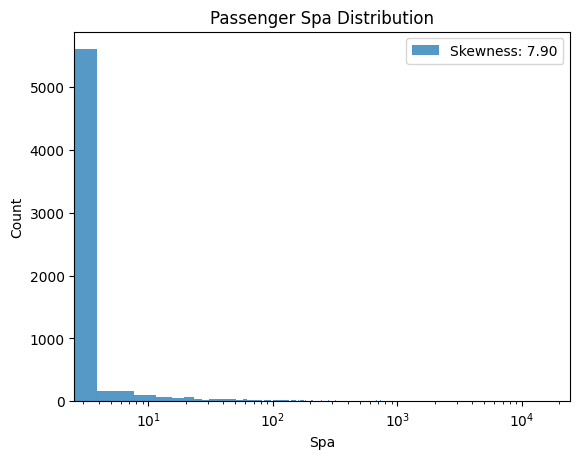

In [53]:
sns.histplot(train_df['Spa'], label = 'Skewness: %.2f'%(train_df['Spa'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Spa Distribution')
plt.xscale('log')
# plt.ylim(0,120)

In [54]:
# Print a count of the rows with a zero RoomService
print(f'Spa is zero in {len(train_df[train_df["Spa"] == 0])} out of {len(train_df)} rows')

# about 60% are zero which is having a big impact on the skew we can address this by bucketing or log transforming

Spa is zero in 5311 out of 8444 rows
